# Part 3 - Predicting the Jobs number - Course correction

- toc: True
- badges: true
- comments: true
- categories: [jupyter]

I am making some changes in course due to new discoveries about the data and also refocusing effort.

The first changes should be clear, I am going to start using Jupyter notebooks as the format for my posts.  The whole point is to show some of the methods and Jupyter notebooks provide a great way to do that.  Thanks to the folks at fastai for their tools and tutorials to help me get started with this.

As with any project, I learn new things as I go along, especiall about the data.

I had said in an earlier post that I would pull the U. of Michigan survey data from the U. Mich site because there was a delay of a month for the data to be available on FRED.  Well, it's not just FRED but overall.  I believe there is some arrnagement with Bloomberg to not publish the data elsewhere for a month.  I also believe that the overall consumer score can be scrapped from the U. Mich site, but not the results for the 5 questions that make up the overall score.  So, the forward looking question results *will* have a delay of 1 month.  Later I will give some notebook code to pull the data from the U. Michigan site automatically using Selenium with Python.  And I guess I will use the overall score and get that from the U. Michigan site.

Another change is that I will add the OECD Consumer and Business confidence indexes to the predictor variables.  I found how to get them via FRED.  There are API's that should work directly with the OECD but if I can get it from FRED then that is much easier for me since I already know how to use one of the Python APIs for that.

Speaking of data in general, I found this note from the SF Fed, https://www.frbsf.org/education/publications/doctor-econ/2013/october/labor-market-indicators-monetary-policy-unemployment-rate/
Seems that I am using a lot of the data sources that the fed uses.  
I am going to add a few of the series mentioned in that document.

One other change not so much related to data but to priorities.  I will spend less time on developing a standard time series regression model.  I am more interested in what I can do with a machine learning ensemble method as well as with a neural net model.

I still have to deal with data at different frequencies. A big shout out to Tom Stark, https://www.philadelphiafed.org/research-and-data/research-contacts/stark, at the Philadelphia Fed for sending me some advice on how to deal with this.  He says to use a Kalman filter. And Tom was nice enough to send me his notes on the subject, comprising of 4 PDF files and over 350 pages.  Very nice Tom, what a real gem you are.

With that as an intro to Part 3, let's get started getting data from FRED.

In [1]:
import os
import sys
import datetime
import inspect
import pandas as pd
import numpy as np
from plotnine import ggplot
import matplotlib as mpl
import matplotlib.pyplot as plt

Print out the versions for Python and non standard library modules

In [2]:
mlist = list(filter(lambda x: inspect.ismodule(x[1]), locals().items()))
vi = sys.version_info
print("version {0}.{1}.{2} of Python".format(vi.major, vi.minor, vi.micro))
for name, mod in mlist:
    if name.startswith("__"):
        continue
    if hasattr(mod, "__version__"):
        print("version {1} of {0}".format(name, mod.__version__))
del mod
del name

version 3.9.2 of Python
version 1.2.3 of pd
version 1.20.1 of np
version 3.3.4 of mpl


## Getting data from FRED using a Python API

The FRED website itself has a pretty nice GUI for plotting data. But I need to download the data so I can use Python or R tools to do the forecasting.

The FRED website gives links to projects you can use to access the FRED data from a variety of languages.
See https://fred.stlouisfed.org/docs/api/fred/
I have used the python one called fredapi, https://github.com/mortada/fredapi, before and will use it here with one modification.  
I will add arguments to limit the series start and end dates.

To use any of the API tools you will need an API Key.
See the instructions here, https://fred.stlouisfed.org/docs/api/api_key.html, to get one and get started.
I keep mine in a file called "fred_api_key".
The fredapi module is in a sibling directory so I add that to my path before importing the module.


In [3]:
sys.path.append('../fredapi')
from fredapi import fred
import fredapi
Fred = fred.Fred(api_key_file="fred_api.key")
print(fredapi.__version__)

0.4.2


## How to identify the data on FRED
To acces the data for a series from FRED you need to know the series id.
You can use the fredapi to search for a series given keywords. 
I already know the series ids I want to use and have them in a csv file, so let's read that in and see the ids and a brief description of the data for each one.

In [4]:
fred_ids = pd.read_csv('fred_ids.csv', index_col=None, sep='|')
fred_ids

,series_id,description
0,USPRIV,BLS private
1,NPPTTL,ADP
2,ICSA,Initial Claims
3,CCSA,Continued Claims
4,JTS1000JOL,Job Openings: Total Private
5,JTS1000HIL,Hires: Total Private
6,JTS1000TSL,Total Separations: Total Private
7,CSCICP03USM665S,OECD US Consumer Confidence
8,BSCICP03USM665S,OECD Business Confidence
9,UNRATE,Unemployment Rate


Now we call the fredapi to get the observations for each series.  I'm only getting the data back to the start of 2007.  I'll print out the number of observations we get of reach series and we will notice the different frequencies.

## FRED and ALFRED
Have I not mentioned ALFRED yet?  The goverment releases, like Nonfarm payrolls, usually get updated in subsequent months,
that is, the initial estimates might be revised up or down.  
FRED just has the latest update.  
You probably want to get the value as released or perhaps the value that was known on a given date.  
You get that from ALFRED.  
Notice in the call below I get *all_releases* and then manipulate the data to only keep the earliest one, or the original.  
The API is the same for FRED and ALFRED, but if you get other than the most current data you will be getting it from ALFRED.  

In [5]:
dfs = []
obs_start = "2007-01-01"
obs_end = datetime.date.today()
for ser in fred_ids.itertuples():
    print("series: {0}, obs_start: {1}, obs_end: {2}".format(ser.series_id,
                                                      obs_start, 
                                                      obs_end))
    try:
        all_df = Fred.get_series_all_releases(series_id=ser.series_id, 
                                              observation_start=obs_start, 
                                              observation_end=obs_end,
                                              verbosity=1)
    except AttributeError as ae:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print(exc_type, fname, exc_tb.tb_lineno)   
        break
    except Exception as exc:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print(exc_type, fname, exc_tb.tb_lineno)
        
    try:
        tdf = all_df.sort_values(by="realtime_start", ascending=True).groupby(by="date").head(1)   
        tdf['series_id'] = ser.series_id
        tdf['date'] = tdf['date'].dt.date  
        print("rows= {0}".format(tdf.shape[0]))
        dfs.append(tdf)
    except Exception as exc:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print(exc_type, fname, exc_tb.tb_lineno)        

obs_df = pd.concat(dfs)
obs_df = obs_df.merge(fred_ids, on='series_id')

series: USPRIV, obs_start: 2007-01-01, obs_end: 2021-05-04
get_series_all_releases <2021-05-04 16:26:54.824712
rows= 171
series: NPPTTL, obs_start: 2007-01-01, obs_end: 2021-05-04
get_series_all_releases <2021-05-04 16:26:55.705826
rows= 171
series: ICSA, obs_start: 2007-01-01, obs_end: 2021-05-04
get_series_all_releases <2021-05-04 16:26:56.506046
rows= 747
series: CCSA, obs_start: 2007-01-01, obs_end: 2021-05-04
get_series_all_releases <2021-05-04 16:26:58.169974
rows= 746
series: JTS1000JOL, obs_start: 2007-01-01, obs_end: 2021-05-04
get_series_all_releases <2021-05-04 16:26:59.786485
rows= 170
series: JTS1000HIL, obs_start: 2007-01-01, obs_end: 2021-05-04
get_series_all_releases <2021-05-04 16:27:00.613813
rows= 170
series: JTS1000TSL, obs_start: 2007-01-01, obs_end: 2021-05-04
get_series_all_releases <2021-05-04 16:27:01.601748
rows= 170
series: CSCICP03USM665S, obs_start: 2007-01-01, obs_end: 2021-05-04
get_series_all_releases <2021-05-04 16:27:02.214859
rows= 171
series: BSCICP0

Merge in the descriptions and have a look at the last few rows.

In [6]:
obs_df.sort_values(by="date", inplace=True)
obs_df['dtime'] = pd.to_datetime(obs_df['date'])  
obs_df.tail(4)

,realtime_start,date,value,series_id,description,dtime
1833,2021-04-22,2021-04-10,3674000.0,CCSA,Continued Claims,2021-04-10
1834,2021-04-29,2021-04-17,3660000.0,CCSA,Continued Claims,2021-04-17
1087,2021-04-22,2021-04-17,547000.0,ICSA,Initial Claims,2021-04-17
1088,2021-04-29,2021-04-24,553000.0,ICSA,Initial Claims,2021-04-24


## Not for HFT
A quick aside about how quickly the data is available on FRED.  The Claims data was released at 8:30 ET on Thursday and I first saw it on FRED and in my download about 10-15 minutes later.  While not fast enough for high frequency trading, still very good.  Also let me say how helpful the folks at FRED have been.  I've emailed them a number of questions and they typically get back to me in a day or so. FRED and ALFRED are great resources.  



## Plot of all the data
Let's have a look at what the series look like over time.
What a shock to the employment situation we've had this year.
Note that in many ways it dwarfs the impact from the 2008 financial crisis.
Note how the business confidence index has bounced back.  Not so much for consumer confidence.
Our target is BLS private.  Looks like the ADP data is tracking it really well and it comes out the week before.

In [7]:
def plot_observations(data_df, xcol, ycol, idcol, ncols, figwd, fight, ylim=(None, None), 
                      xtick_rot=0, sharex=True):
    fig = None
    ids = list(data_df[idcol].unique())
    nrows = int(np.ceil(len(ids)/float(ncols)))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[figwd, fight], sharex=sharex)
    gdf = data_df.groupby(by='description')
    for i, (key, group) in enumerate(gdf):
        row = i // ncols
        col = i % ncols
        ax = axs[row][col]
        group.plot(ax=ax, kind='line', x=xcol, y=ycol,linestyle='-', marker='o', lw=1, ylim=ylim,
                   mec='red', mfc='black', ms=0.75,  title=key, legend=None, label=None, grid=True)
        ax.xaxis.set_tick_params(rotation=xtick_rot)         
    return fig  

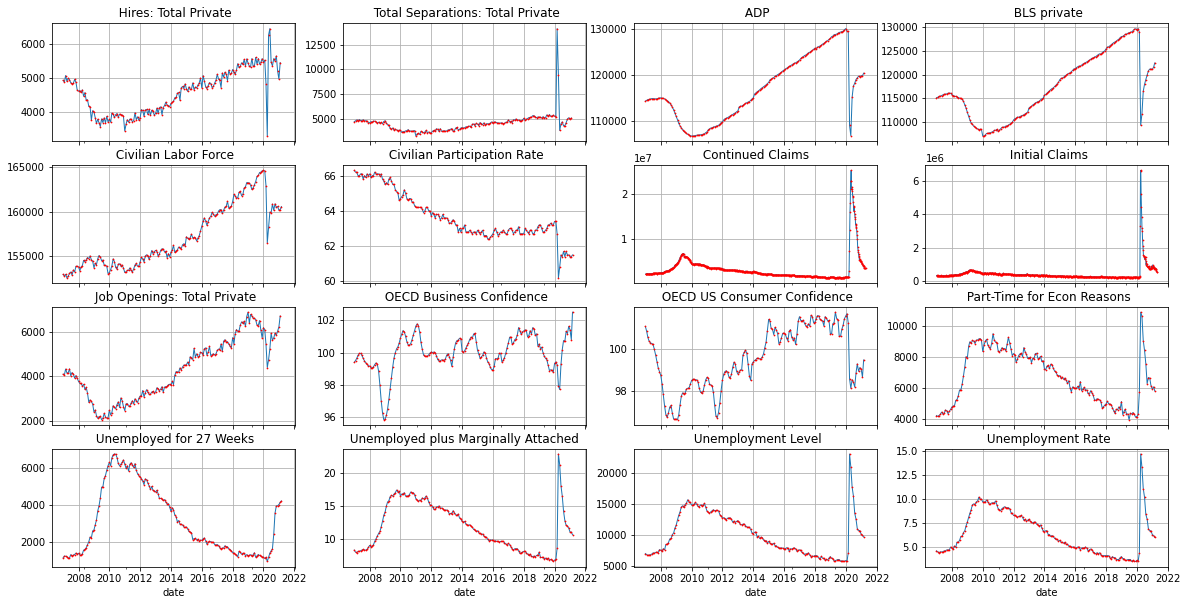

In [8]:
ylim=(None, None)
fig = plot_observations(data_df=obs_df, xcol='date', ycol='value', idcol='description', ncols=4,
                  figwd=20, fight=10, ylim=(None,None))  

## Plot of the last year
Let's focus in on data from 2020.  Notice how some of the series are almost current while others are lagging more than a month.

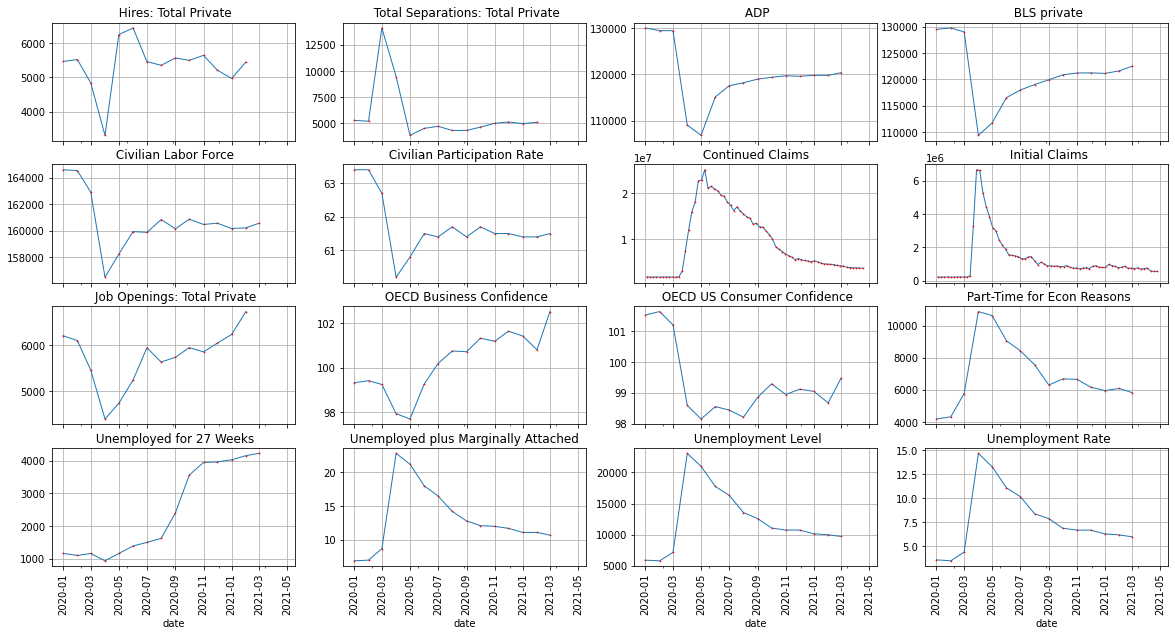

In [9]:
temp_df = obs_df[obs_df['date'] >= datetime.date.today() - datetime.timedelta(weeks=52)]
temp_df = obs_df[obs_df['date'] >= datetime.date(year=2020, month=1, day=1)]
ylim=(None, None)
fig = plot_observations(data_df=temp_df, xcol='date', ycol='value', idcol='description', ncols=4,
                  figwd=20, fight=10, ylim=(None,None), xtick_rot=90) 


    save the dataframe into the output directory

In [13]:
out_dir = "./data"
if False:
  if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
  obs_df.to_csv(os.path.join(out_dir, "fred.csv"))

## Tidy Fred


In [14]:
cols = ["date", "value"]
series_ids = obs_df["series_id"].unique()
dfs = []
tidy_df = pd.DataFrame()
for sid in series_ids:
    x = obs_df.loc[obs_df["series_id"]==sid,cols]
    x.columns = ["date", sid]
    if tidy_df.shape[0] == 0:
        tidy_df = x
    else:
        tidy_df = tidy_df.merge(x, how="outer", on="date")
tidy_df.sort_values(by="date", inplace=True)
tidy_df.set_index("date", inplace=True)
scols = ["USPRIV", "ICSA", "JTS1000JOL"]
print(tidy_df[scols].head(10))
print(tidy_df[scols].tail(10))
tidy_df.to_csv("./data/tidy_fred.csv")

              USPRIV      ICSA JTS1000JOL
date                                     
2007-01-01  115137.0       NaN     4102.0
2007-01-06       NaN  322000.0        NaN
2007-01-13       NaN  295000.0        NaN
2007-01-20       NaN  337000.0        NaN
2007-01-27       NaN  309000.0        NaN
2007-02-01  115242.0       NaN     4069.0
2007-02-03       NaN  307000.0        NaN
2007-02-10       NaN  332000.0        NaN
2007-02-17       NaN  323000.0        NaN
2007-02-24       NaN  319000.0        NaN
              USPRIV      ICSA JTS1000JOL
date                                     
2021-02-27       NaN  745000.0        NaN
2021-03-01  122507.0       NaN        NaN
2021-03-06       NaN  712000.0        NaN
2021-03-13       NaN  770000.0        NaN
2021-03-20       NaN  684000.0        NaN
2021-03-27       NaN  719000.0        NaN
2021-04-03       NaN  744000.0        NaN
2021-04-10       NaN  576000.0        NaN
2021-04-17       NaN  547000.0        NaN
2021-04-24       NaN  553000.0    

That's all for now on FRED data.
Next up, U. Michigan data and Google Trends data.

In [15]:
import datetime
print(datetime.datetime.now())

2021-05-04 16:30:05.633565
